# Reduced fragment library

## Aim of this notebook

The fragment library resulting from the KinFragLib fragmentation procedure comprises of about 3000 fragments. Ultimately, we want to demonstrate how this library can be used for recombining ligands. Before this can be done, we need to address two considerations:

1. Remove all fragments that are not useful in a recombination, i.e. duplicates, fragments in pool X, fragments without dummy atoms, and fragments with dummy atoms only connecting to pool X.
2. Select a diverse set of fragments (per subpocket) for recombination to (i) save computational cost and (ii) avoid recombination of highly similar fragments.

Furthermore, we want to know (i) which original ligands can be fully recombined by the reduced fragment library and (ii) how many original ligands are represented by at least one fragment. This will help us to check our combinatorial library for expected results.

## Table of contents

1. Load fragment library (from csv file)
2. Filter fragment library
3. Cluster filtered fragments 
4. Select cluster centroids (get diverse set of fragments)
5. Load fragment library (from sdf files)
6. Which fragments in the full library are in the reduced library?
7. How many ligands are fully covered by the reduced library?
8. Save reduced fragment library (as sdf files and csv file)

## Notebook dependencies

Needs output from notebook `fragment_library.ipynb`.

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools

from util import *

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
PATH_DATA = Path('.') / '..' / 'data'

# Create new folder for reduced fragment library
(PATH_DATA / 'fragment_library_reduced').mkdir(parents=True, exist_ok=True)

In [5]:
DISTANCE_CUTOFF = 0.6

## 1. Load fragment library (from csv file)

(7486, 13)


,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,subpocket,atom_subpockets,atom_environments,smiles,smiles_dummy_atoms,ROMol
0,AAK1,NAK,Other,5l4q,LKB,B,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,
1,AAK1,NAK,Other,5te0,XIN,,A,AP,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,

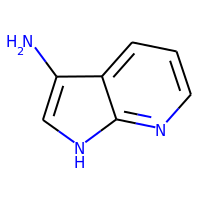
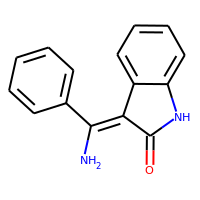

In [6]:
fragment_library_concat = pd.read_csv('../data/fragment_library/fragment_library.csv')
PandasTools.AddMoleculeColumnToFrame(fragment_library_concat, 'smiles')

print(fragment_library_concat.shape)
fragment_library_concat.head(2)

In [7]:
fragment_library_concat.groupby('subpocket', sort=False).size()

subpocket
AP    2561
FP    1866
SE    1560
GA    1024
B1      98
B2      92
X      285
dtype: int64

## 2. Filter fragment library

Filter steps:

1. Remove pool X
2. Deduplicate fragment library (per subpocket)
3. Remove fragments without dummy atoms (unfragmented ligands)
4. Remove all fragments that connect only to pool X
5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)

### 2.1. Remove pool X

In [8]:
# Remove pool X
fragment_library_concat_filtered = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()
print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.subpocket.unique()

(7201, 13)


array(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'], dtype=object)

### 2.2. Deduplicate fragment library (per subpocket)

(2977, 13)


,subpocket,smiles,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy_atoms,ROMol
0,AP,Nc1c[nH]c2ncccc12,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,

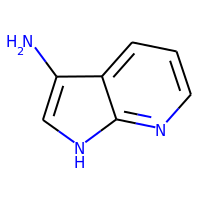
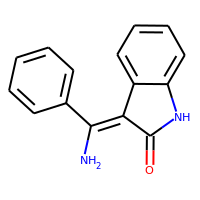

In [9]:
fragment_library_concat_filtered = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).first().reset_index()
print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.head(2)

In [10]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1115
FP     864
SE     607
GA     306
B1      42
B2      43
dtype: int64

### 2.3. Remove fragments without dummy atoms (unfragmented ligands)

In [11]:
# Get fragments' (subpocket) connections 
fragment_library_concat_filtered['connections'] = get_connections_by_fragment(fragment_library_concat_filtered).connections

In [12]:
# Unfragmented ligands?
bool_unfragmented_ligands = fragment_library_concat_filtered.connections.apply(lambda x: len(x) == 0)
bool_unfragmented_ligands.head()

0    False
1    False
2    False
3    False
4    False
Name: connections, dtype: bool

In [13]:
# Remove unfragmented ligands
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_unfragmented_ligands
].copy()
print(fragment_library_concat_filtered.shape)

(2863, 15)


In [14]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1001
FP     864
SE     607
GA     306
B1      42
B2      43
dtype: int64

### 2.4. Remove all fragments that connect only to pool X

In [15]:
# Fragment connects only to pool X?
bool_only_pool_x_connections = fragment_library_concat_filtered.connections.apply(
    lambda x: all(  # All connections per fragment X?
        [True if 'X' in i else False for i in x]  # Connections per fragment X or not?
    )
)

In [16]:
# Remove fragments that connect only to pool X
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_only_pool_x_connections
].copy()
print(fragment_library_concat_filtered.shape)

(2862, 15)


In [17]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1001
FP     864
SE     607
GA     306
B1      42
B2      42
dtype: int64

### 5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)

Rule of Three criteria ([paper](https://www.sciencedirect.com/science/article/pii/S1359644603028319)):
- Molecular weight < 300 Da
- LogP <= 3
- Number of HBA <= 3 
- Number of HBD <= 3
- Number of rotatable bonds <= 3 
- Polar surface area (PSA) <= 60 $\mathring{A}$<sup>2</sup>

In [18]:
ro3 = fragment_library_concat_filtered.ROMol.apply(lambda x: get_ro3_from_mol(x))

In [19]:
# Fragments fulfill all six Ro3 rules
bool_fulfill_ro3 = ro3.sum(axis=1) == 6

In [20]:
fragment_library_concat_filtered = fragment_library_concat_filtered[
    bool_fulfill_ro3
].copy()
print(fragment_library_concat_filtered.shape)

(2029, 15)


In [21]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    516
FP    655
SE    501
GA    278
B1     39
B2     40
dtype: int64

## 3. Cluster filtered fragments

In [22]:
def get_cluster_centroids(fragment_library_concat, subpocket, cutoff):
    """
    Cluster fragments by subpocket and get cluster centroids including the respective cluster sizes.
    
    Parameters
    ----------
    fragment_library_concat : pandas.DataFrame
        Fragment library data for one or multiple subpockets.
    subpocket : str
        Subpocket name, i.e. AP, SE, FP, GA, B1, or B2.
    cutoff : float
        Distance cutoff Butina clustering.
        
    Returns
    -------
    pandas.DataFrame
        Cluster centroids (molecule ID) and cluster sizes.
    """

    # Get fragments by subpocket
    fragments = fragment_library_concat_filtered[fragment_library_concat.subpocket == subpocket].copy()
    fragments.reset_index(inplace=True, drop=True)
    fragments.index.name = 'molecule_id'

    # Generate fingerprints
    fragments['fingerprint'] = generate_fingerprints(fragments.ROMol)

    # Cluster fingerprints
    clusters = cluster_molecules(fragments.fingerprint, cutoff)

    # Select cluster centroids (first cluster member)
    cluster_centroids = clusters.groupby('cluster_id').first()
    cluster_centroids['cluster_size'] = clusters.groupby('cluster_id').size()
    cluster_centroids.reset_index(inplace=True)
    cluster_centroids = fragments.merge(
        cluster_centroids,
        on='molecule_id',
    ).sort_values('cluster_id')
    
    return cluster_centroids

In [23]:
def draw_cluster_centroids(cluster_centroids, output_path=None):
    """
    Draw fragments sorted by descending cluster size and fragment count.
    
    Parameters
    ----------
    cluster_centroids : pandas.DataFrame
        Fragments that are cluster centroids (cluster ID as index, molecule ID, cluster size, and ROMol).   
    output_path : pathlib.Path
        Path to output folder.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments sorted by descending cluster size.
    """
    
    subpocket = cluster_centroids.subpocket.unique()[0]
        
    img = Draw.MolsToGridImage(
        list(cluster_centroids.ROMol), 
        legends=[
            f'{row.cluster_id} | {row.cluster_size}' 
            for index, row
            in cluster_centroids.iterrows()
        ],  
        molsPerRow=7, 
        maxMols=200,
        subImgSize=(170, 170),
        useSVG=True
    )
    
    print(f'Legend: cluster ID | cluster size')
    
    if output_path is not None:
        
        # Get SVG data
        molsvg = img.data

        # Set font size
        molsvg = molsvg.replace('12px', '24px');

        # Save altered SVG data to file
        with open(Path(output_path) / f'clustered_most_common_fragments_{subpocket.lower()}.svg', 'w') as f:
            f.write(molsvg)
    
    return img

### Cluster fragments per subpocket

In [24]:
def get_cluster_centroids_all_subpockets(fragment_library_concat):
    """
    Get cluster centroids per subpocket.
    
    Parameters
    ----------
    fragment_library_concat : pandas.DataFrame
        Fragment library data for one or multiple subpockets.
    
    Returns
    -------
    pandas.DataFrame
        Fragments that are cluster centroids (cluster ID as index, molecule ID, cluster size, and ROMol).   
    """
    
    cluster_centroids_subpockets = {}

    for subpocket, fragments in fragment_library_concat.groupby('subpocket', sort=False):
        print(f'\nSubpocket: {subpocket}')
        cluster_centroids_subpocket = get_cluster_centroids(fragment_library_concat_filtered, subpocket, cutoff=DISTANCE_CUTOFF)
        cluster_centroids_subpocket['subpocket'] = subpocket
        cluster_centroids_subpockets[subpocket] = cluster_centroids_subpocket

    # Concatenate cluster centroids for all subpockets
    cluster_centroids = pd.concat(cluster_centroids_subpockets).reset_index(drop=True)
    
    return cluster_centroids

In [25]:
cluster_centroids = get_cluster_centroids_all_subpockets(fragment_library_concat_filtered)


Subpocket: AP
Number of molecules: 516
Threshold:  0.6
Number of clusters:  133
# Clusters with only 1 molecule:  70
# Clusters with more than 5 molecules:  21
# Clusters with more than 25 molecules:  1
# Clusters with more than 100 molecules:  0

Subpocket: FP
Number of molecules: 655
Threshold:  0.6
Number of clusters:  170
# Clusters with only 1 molecule:  83
# Clusters with more than 5 molecules:  29
# Clusters with more than 25 molecules:  4
# Clusters with more than 100 molecules:  0

Subpocket: SE
Number of molecules: 501
Threshold:  0.6
Number of clusters:  120
# Clusters with only 1 molecule:  58
# Clusters with more than 5 molecules:  19
# Clusters with more than 25 molecules:  4
# Clusters with more than 100 molecules:  0

Subpocket: GA
Number of molecules: 278
Threshold:  0.6
Number of clusters:  84
# Clusters with only 1 molecule:  44
# Clusters with more than 5 molecules:  11
# Clusters with more than 25 molecules:  1
# Clusters with more than 100 molecules:  0

Subpocke

,cluster_id,molecule_id,cluster_size,ROMol
0,1,166,78,
1,2,233,24,

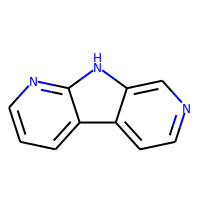
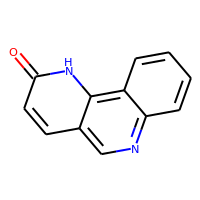

In [26]:
cluster_centroids[['cluster_id', 'molecule_id', 'cluster_size', 'ROMol']].head(2)

### Plot cluster sizes per subpocket

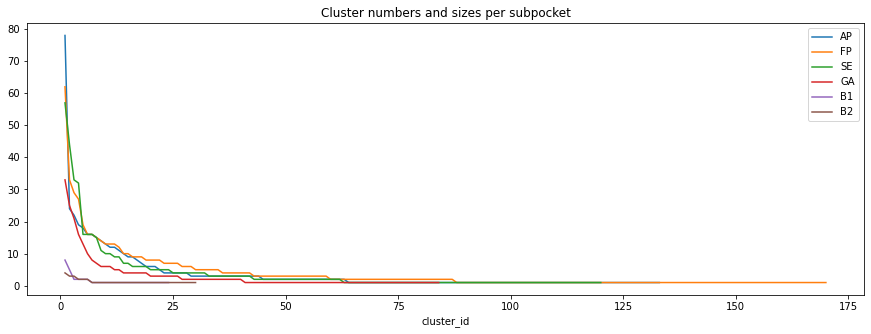

In [27]:
cluster_data = pd.concat(
    [
        cluster_centroids_subpocket.set_index('cluster_id')['cluster_size'] 
        for subpocket, cluster_centroids_subpocket 
        in cluster_centroids.groupby('subpocket', sort=False)
    ], 
    axis=1
)
cluster_data.columns = cluster_centroids.groupby('subpocket', sort=False).groups.keys()
cluster_data.plot(figsize=(15,5), title='Cluster numbers and sizes per subpocket')

## 4. Select cluster centroids (get diverse set of fragments)

### Number of centroids per subpocket and in total

In [28]:
cluster_centroids.groupby('subpocket', sort=False).size()

subpocket
AP    133
FP    170
SE    120
GA     84
B1     24
B2     30
dtype: int64

In [29]:
print(f'Number of centroids in total = size of reduced fragment library: {cluster_centroids.shape[0]}')

Number of centroids in total = size of reduced fragment library: 561


### Fragments in AP

Legend: cluster ID | cluster size


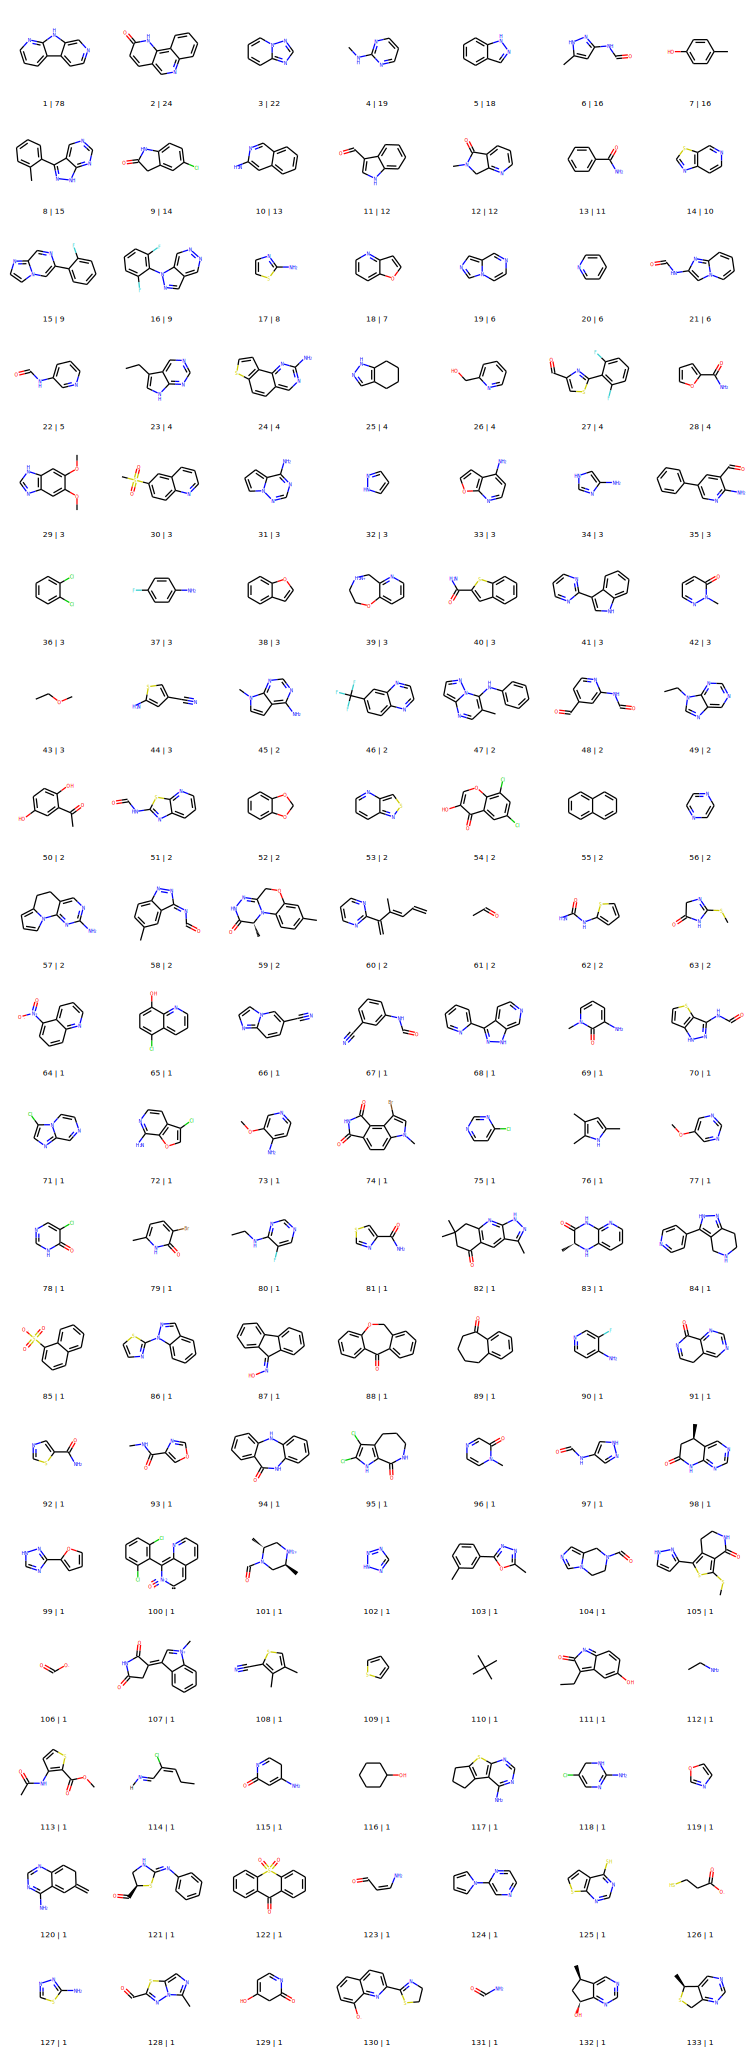

In [30]:
draw_cluster_centroids(cluster_centroids.groupby('subpocket').get_group('AP'), output_path=None)

### Fragments in FP

Legend: cluster ID | cluster size


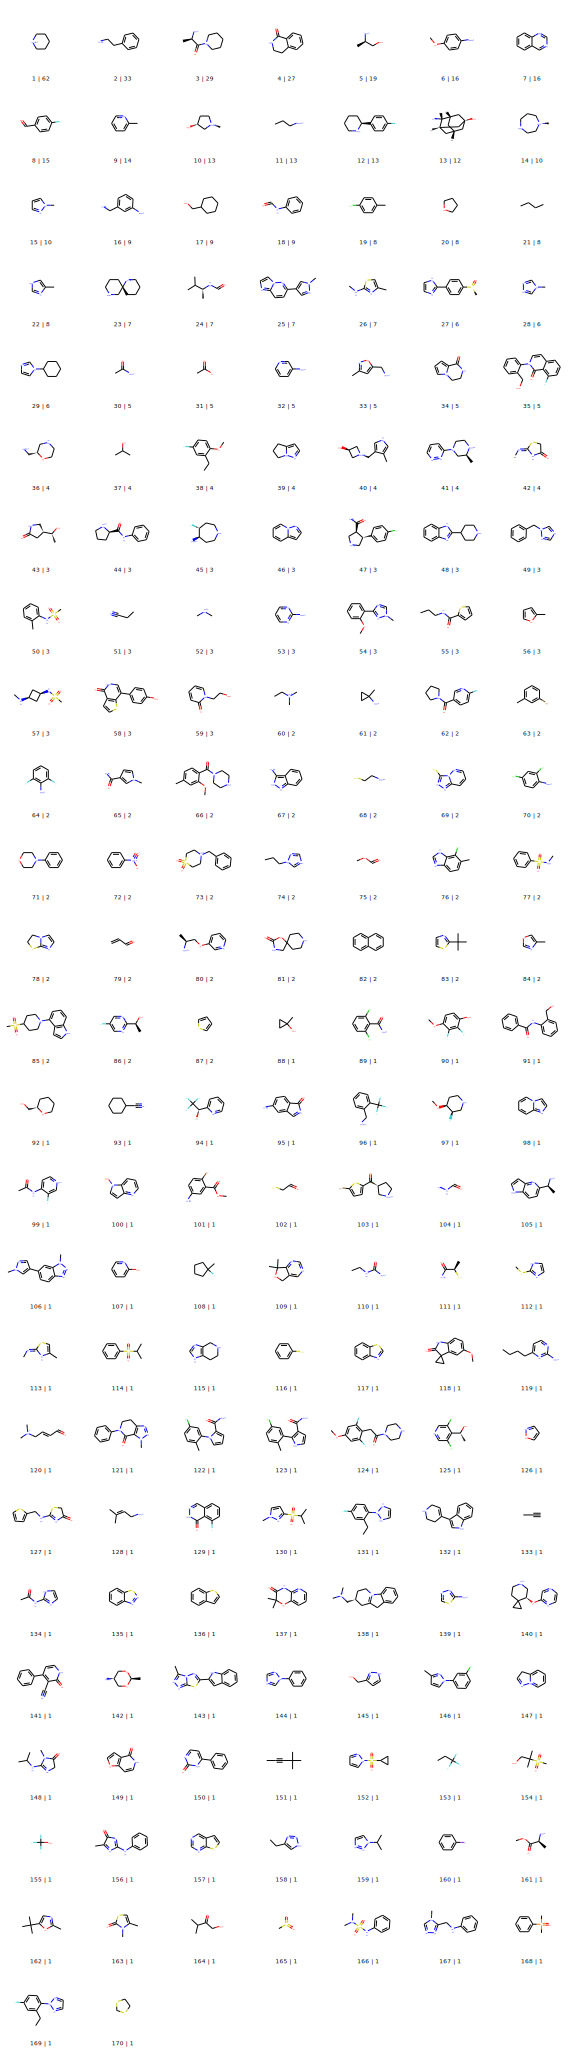

In [31]:
draw_cluster_centroids(cluster_centroids.groupby('subpocket').get_group('FP'), output_path=None)

### Fragments in SE

Legend: cluster ID | cluster size


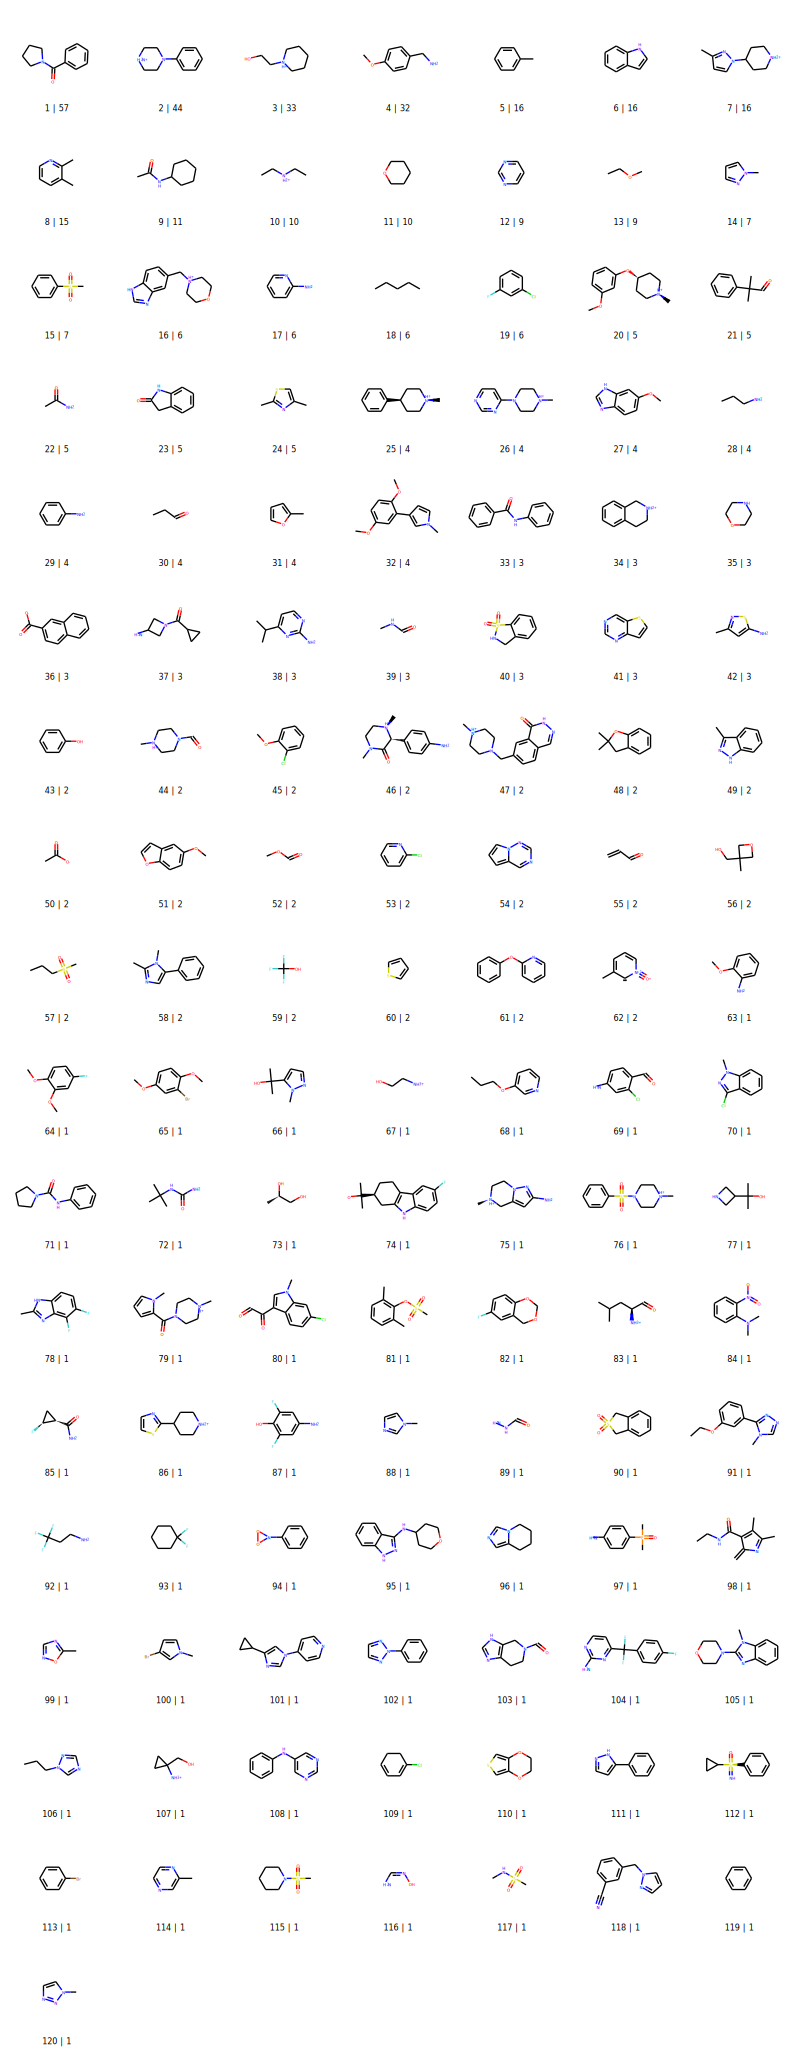

In [32]:
draw_cluster_centroids(cluster_centroids.groupby('subpocket').get_group('SE'), output_path=None)

### Fragments in GA

Legend: cluster ID | cluster size


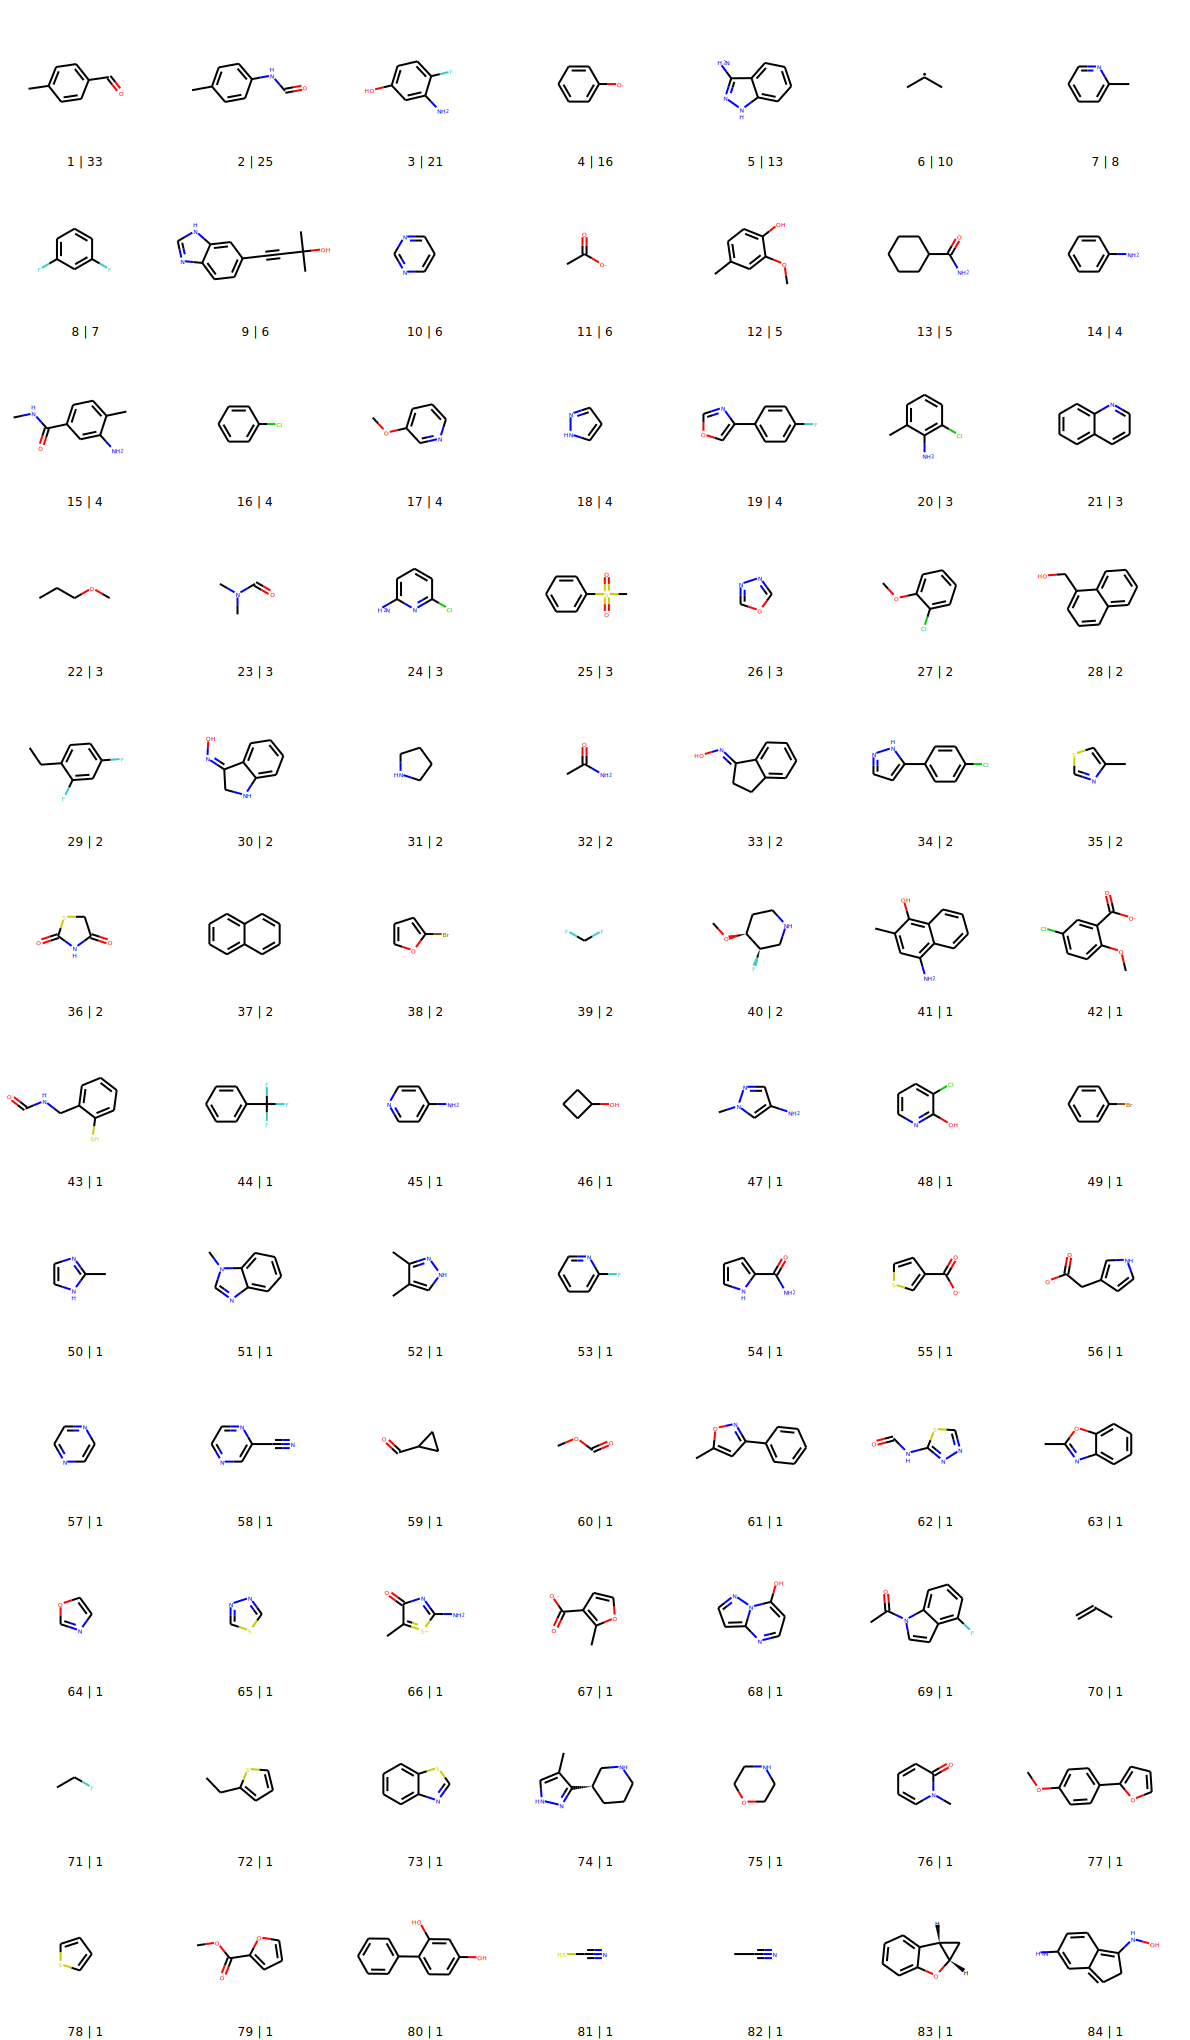

In [33]:
draw_cluster_centroids(cluster_centroids.groupby('subpocket').get_group('GA'), output_path=None)

### Fragments in B1

Legend: cluster ID | cluster size


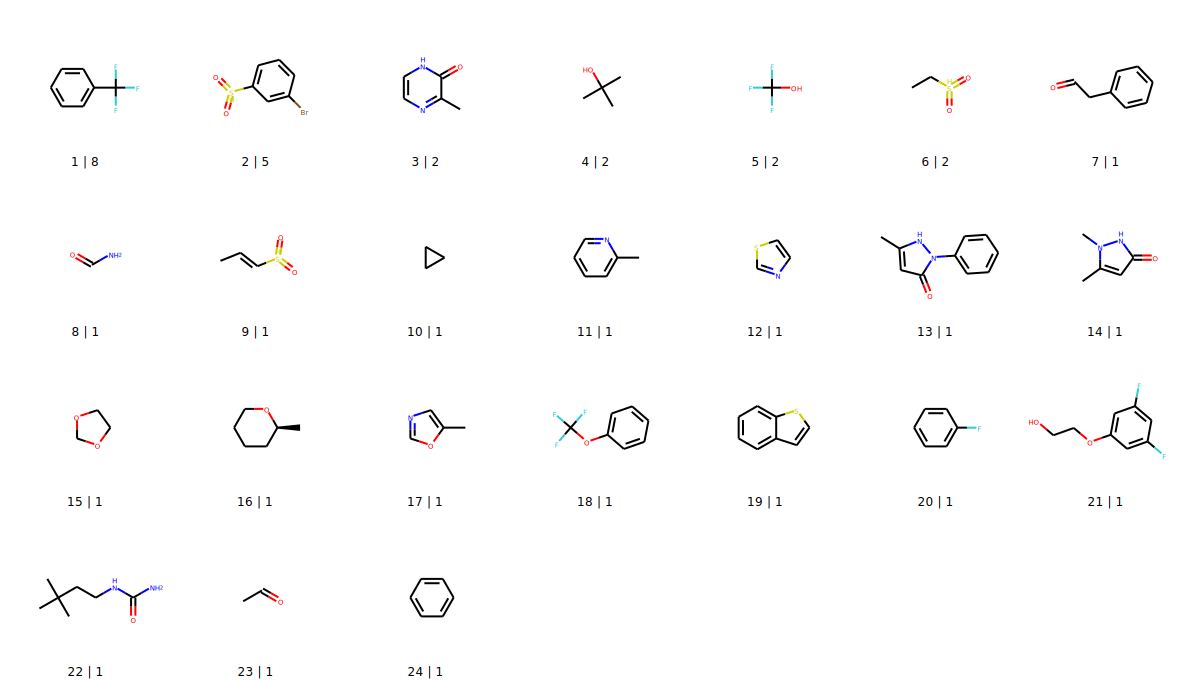

In [34]:
draw_cluster_centroids(cluster_centroids.groupby('subpocket').get_group('B1'), output_path=None)

### Fragments in B2

Legend: cluster ID | cluster size


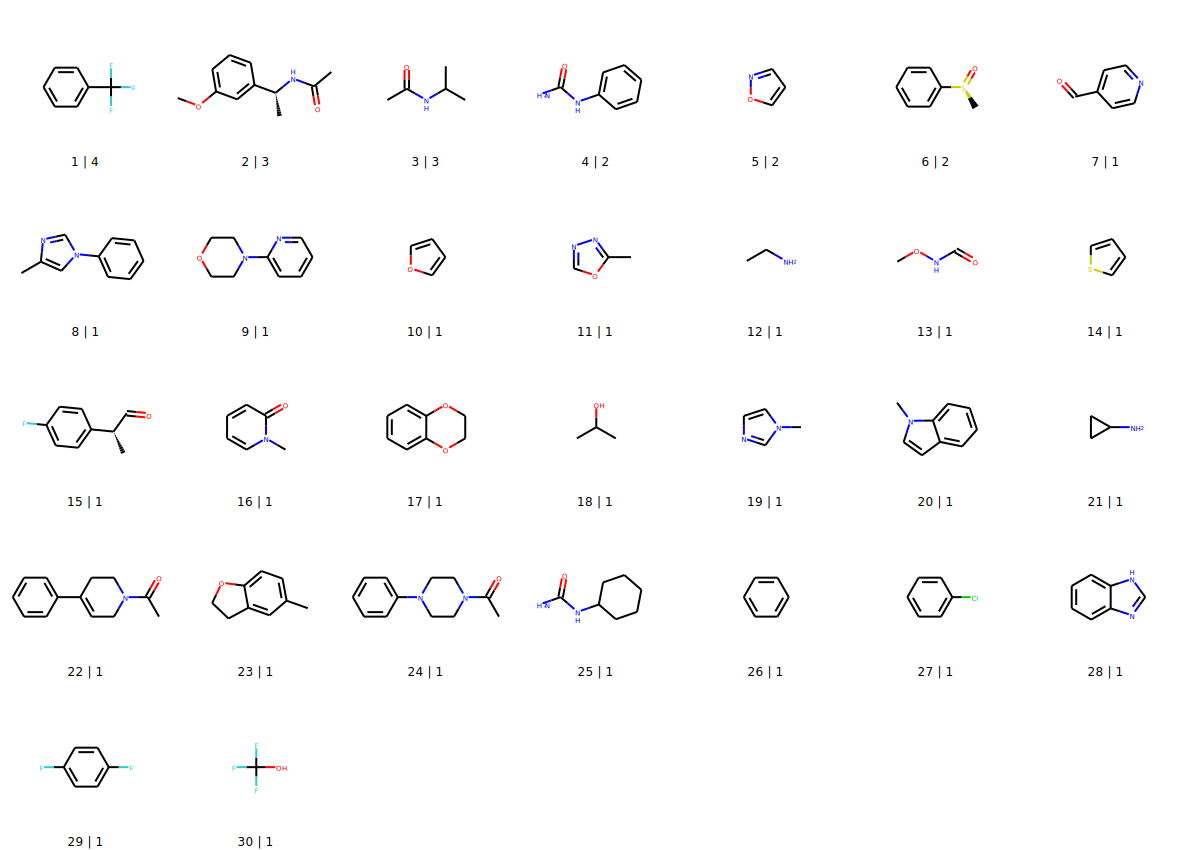

In [35]:
draw_cluster_centroids(cluster_centroids.groupby('subpocket').get_group('B2'), output_path=None)

## 5. Load fragment library (from sdf files)

Why, don't we have them already? Yes, we do, but without their original 3D coordinates. Although we do not need them in the current implementation of our recombination algorithm, we might be interested in the future.

In [36]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

## 6. Which fragments in the full library are in the reduced library?

Loop over each subpocket pool in the full library and ask for each fragment if it is part of the respective reduced library's subpocket pool?

In [37]:
for subpocket, fragments in fragment_library.items():

    fragments['subpocket'] = subpocket
    
    if subpocket != 'X':
        
        fragments_reduced = cluster_centroids.groupby('subpocket', sort=False).get_group(subpocket)
        
        smiles_match = fragments.smiles.isin(fragments_reduced.smiles)
        atom_environments_match = fragments.atom_environments.isin(fragments_reduced.atom_environments)
        fragments['in_reduced_library'] = smiles_match & atom_environments_match
    else:
        fragments['in_reduced_library'] = False

In [38]:
print(f'How many fragments are in reduced fragment library?')
print(cluster_centroids.shape[0])

print(f'How many fragments in reduced library are part of full library? (sanity check)')
print(sum([fragments.groupby(['subpocket', 'smiles']).first().in_reduced_library.sum() for subpocket, fragments in fragment_library.items()]))

How many fragments are in reduced fragment library?
561
How many fragments in reduced library are part of full library? (sanity check)
561


## 7. How many ligands are fully covered by the reduced library?

In [39]:
ligand_is_fully_covered = pd.concat(fragment_library).groupby(['kinase', 'complex_pdb', 'ligand_pdb'], sort=False).apply(
    lambda ligand: all(ligand.in_reduced_library)
)
ligand_is_fully_covered.name = 'is_fully_covered'
ligand_is_fully_covered.head()

kinase  complex_pdb  ligand_pdb
AAK1    5l4q         LKB           False
        5te0         XIN           False
ABL1    2f4j         VX6           False
        2gqg         1N1           False
        2v7a         627           False
Name: is_fully_covered, dtype: bool

In [40]:
print(f'Number of fully covered ligands by reduced fragment library: {ligand_is_fully_covered[ligand_is_fully_covered].shape[0]}')

Number of fully covered ligands by reduced fragment library: 11


In [41]:
pdb_ids = list(ligand_is_fully_covered[ligand_is_fully_covered].reset_index().complex_pdb.unique())

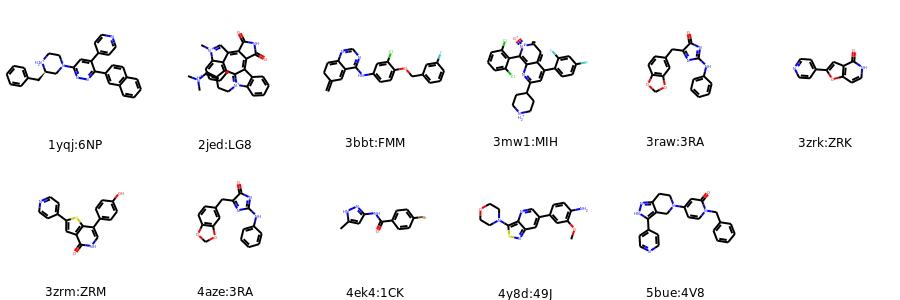

In [42]:
draw_ligands_from_pdb_ids(pdb_ids, mols_per_row=6)

## 8. Save reduced fragment library (as sdf files and csv file)

In [43]:
def prepare_fragment_library_reduced(fragment_library):
    """
    Prepare data for sdf file (one file per subpocket) writing: Get fragment library (per subpocket) containing only fragments from the reduced fragment library.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key), including "in_reduced_library" column.
        
    Returns
    -------
    dict of pandas.DataFrame
        Fragment details for reduced fragment library, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key), including "in_reduced_library" column.
    """

    fragment_library_reduced = fragment_library.copy()

    for subpocket, fragments in fragment_library_reduced.items():

        fragment_library_reduced[subpocket] = fragments[fragments.in_reduced_library == True]

    del fragment_library_reduced['X']
    
    return fragment_library_reduced

In [44]:
fragment_library_reduced = prepare_fragment_library_reduced(fragment_library)

### Save to sdf files

In [45]:
def save_reduced_fragment_library_to_sdfs(path_data, fragment_library_reduced, cutoff):
    """
    Save reduced fragment library to file (for each subpocket sdf file, all in a newly (if not existing) created "fragment_library_reduced" folder).
    
    Parameters
    ----------
    path_data : str or pathlib.Path
        Path to data folder (containing folders for fragment library and reduced fragment library).
    fragment_library_reduced : dict of pandas.DataFrame
        Fragment details for reduced fragment library, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key), including "in_reduced_library" column.
    cutoff : float
        Distance cutoff Butina clustering.
    """
    
    path_fragment_library_reduced = Path(path_data) / 'fragment_library_reduced'
    path_fragment_library_reduced.mkdir(parents=True, exist_ok=True)
    
    for subpocket, fragments in fragment_library_reduced.items():
        
        with open(path_fragment_library_reduced / f'{subpocket}_reduced_{cutoff}.sdf', 'w') as f:
            w = Chem.SDWriter(f)
            for mol in fragments.ROMol:
                w.write(mol)
            w.close()

In [46]:
save_reduced_fragment_library_to_sdfs(PATH_DATA, fragment_library_reduced, DISTANCE_CUTOFF)

### Save to csv file

In [47]:
def save_reduced_fragment_library_to_csv(path_data, fragment_library_concat_reduced, cutoff):
    """
    Save reduced fragment library to file (csv file, all in a newly (if not existing) created "fragment_library_reduced" folder).
    
    Parameters
    ----------
    path_data : str or pathlib.Path
        Path to data folder (containing folders for fragment library and reduced fragment library).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    cutoff : float
        Distance cutoff Butina clustering.
    """
    
    path_fragment_library_reduced = path_data / 'fragment_library_reduced'
    path_fragment_library_reduced.mkdir(parents=True, exist_ok=True)
    
    # Make copy of DataFrame for editing
    fragment_library_concat_reduced = fragment_library_concat_reduced.copy()
    
    # Save columns which are dropped in next step but will be added again at desired position
    column_smiles = fragment_library_concat_reduced.smiles
    column_subpockets = fragment_library_concat_reduced.subpocket
    
    # Drop columns (unneeded columns and columns that will be move to other position)
    fragment_library_concat_reduced.drop(
        ['ROMol', 'fingerprint', 'molecule_id', 'connections', 'connections_name', 'smiles', 'subpocket'], 
        axis=1,
        inplace=True
    )
    
    # Insert back columns which needed to be moved (to have the same order as in full library equivalent csv file)
    fragment_library_concat_reduced.insert(7, 'subpocket', column_subpockets)
    fragment_library_concat_reduced.insert(10, 'smiles', column_smiles)
    
    # Save to csv
    fragment_library_concat_reduced.to_csv(
        path_fragment_library_reduced / f'fragment_library_reduced_{cutoff}.csv', 
        index=False
    )

In [48]:
save_reduced_fragment_library_to_csv(PATH_DATA, cluster_centroids, DISTANCE_CUTOFF)